In [1]:
import tensorflow as tf
print("TF",tf.__version__)

import time
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.applications import ResNet152V2,ResNet50V2
from tensorflow.keras.models import Sequential

TF 2.9.1


In [2]:
# data 불러오기
data_dir = 'dataset'
train_dir = os.path.join(data_dir,"data")
train_fnames = os.listdir(train_dir)
NUM_CLASSES = len(train_fnames)
print(NUM_CLASSES)

127


In [3]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                horizontal_flip = False,
                                validation_split=0.1)

train_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode="categorical",
                                              shuffle = True,
                                              subset='training')
validation_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode="categorical",
                                              shuffle = True,
                                              subset='validation')

Found 23523 images belonging to 127 classes.
Found 2558 images belonging to 127 classes.


In [4]:
earlystopping = EarlyStopping(monitor='val_accuracy', 
                              patience=20,
                              mode = 'max'         
                             )

reduceLR = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.1,         
    patience=5,         
    min_lr=1e-5
)

In [8]:
def model_learning(Model,model_name,train_data,validation_data):
    model = Sequential()
    model = Model
    model.compile(optimizer = Adam(1e-2),
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

    history = model.fit(train_data,
                    epochs = 100,
                    batch_size=128,
                    validation_data = validation_data,
                    callbacks=[reduceLR , earlystopping],
                    )
#################################################################################    
    his_dict = history.history
    loss = his_dict['loss']
    val_loss = his_dict['val_loss'] 

    epochs = range(1, len(loss) + 1)
    fig = plt.figure(figsize = (15, 10))

# 훈련 및 검증 손실 그리기
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, loss, color = 'blue', label = 'train loss')
    ax1.plot(epochs, val_loss, color = 'red',linestyle='--', label = 'validation loss')
    ax1.set_title('train and val loss')
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('loss')
    ax1.legend()

    acc = his_dict['accuracy']
    val_acc = his_dict['val_accuracy']

# 훈련 및 검증 정확도 그리기
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, acc, color = 'blue', label = 'train accuracy')
    ax2.plot(epochs, val_acc, color = 'red',linestyle='--', label = 'validation accuracy')
    ax2.set_title('train and val accuracy')
    ax2.set_xlabel('epochs')
    ax2.set_ylabel('accuracy')
    ax2.legend()

    model.save(str(model_name)+".h5")    
    plt.savefig(str(model_name)+".png",dpi=200)

    tf.keras.backend.clear_session()

    return

In [9]:
def model_generator(train_model,layers_number):

    x=train_model.layers[-2].output
    predict_layer = tf.keras.layers.Dense(127,activation="softmax")(x)
    model = Sequential()
    model = tf.keras.Model(inputs=train_model.input,outputs=predict_layer)

    for layer in model.layers[:-layers_number]:
        layer.trainable=False

    for layer in model.layers[-layers_number:]:
        layer.trainable=True

    return model

In [10]:
ResNet50V2_model=ResNet50V2(include_top=True, weights='imagenet', input_tensor=None,
    input_shape=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

model = model_generator(ResNet50V2_model,-10)
model.summary()

# model_name = "test1"

# model_learning(model,model_name,train_data,validation_data)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

Epoch 1/3
736/736 [==============================] - 142s 178ms/step - loss: 1.8516 - accuracy: 0.5264 - val_loss: 1.2857 - val_accuracy: 0.6321 - lr: 1.0000e-04
Epoch 2/3
736/736 [==============================] - 119s 161ms/step - loss: 0.6789 - accuracy: 0.7985 - val_loss: 1.1800 - val_accuracy: 0.6673 - lr: 1.0000e-04
Epoch 3/3
736/736 [==============================] - 119s 161ms/step - loss: 0.2988 - accuracy: 0.9176 - val_loss: 1.2904 - val_accuracy: 0.6505 - lr: 1.0000e-04


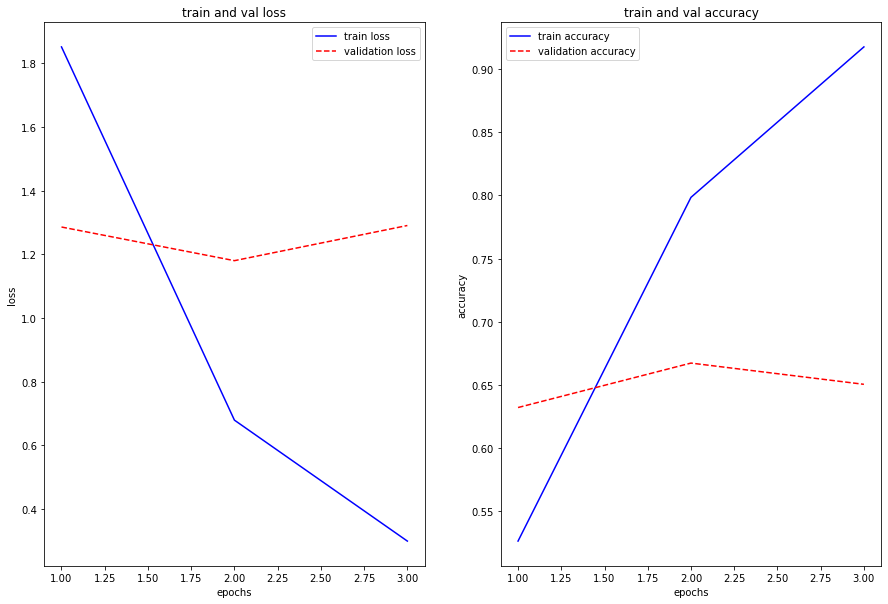

In [11]:
model_name = "ResNet50V2_model"

model_learning(model,model_name,train_data,validation_data)